In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn. ensemble as ske
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import random
import librosa, IPython
import librosa.display as lplt
import IPython.display as ipd
import os
from os import path
from pydub import AudioSegment
from pydub.utils import make_chunks
import eli5
from eli5.sklearn import PermutationImportance

In [18]:
#Reading Data
musicData = pd.read_csv(r"features_30_sec.csv")
print(musicData.head())
print("Dataset has", musicData.shape)

          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516        

In [19]:
#Checking for null values in the data
print ("columns with null values are ", list(musicData.columns[musicData.isnull().any()]))

#since there are no null values in the data we don't need to create any dummy values

columns with null values are  []


'\n    in the heat map, warm colors represent hig values and cool values represent low values. Values in a correlation matrix\n    range from -1 to 1. A value of one indicates a perfect positive correlation meaning as one value increases, the other\n    also increases. A value of -1 indicates a perfect negative correlation meaning as one value \n    increases, the other decreases. Avalue of 0 indicates no correlation between the variables.\n\n'

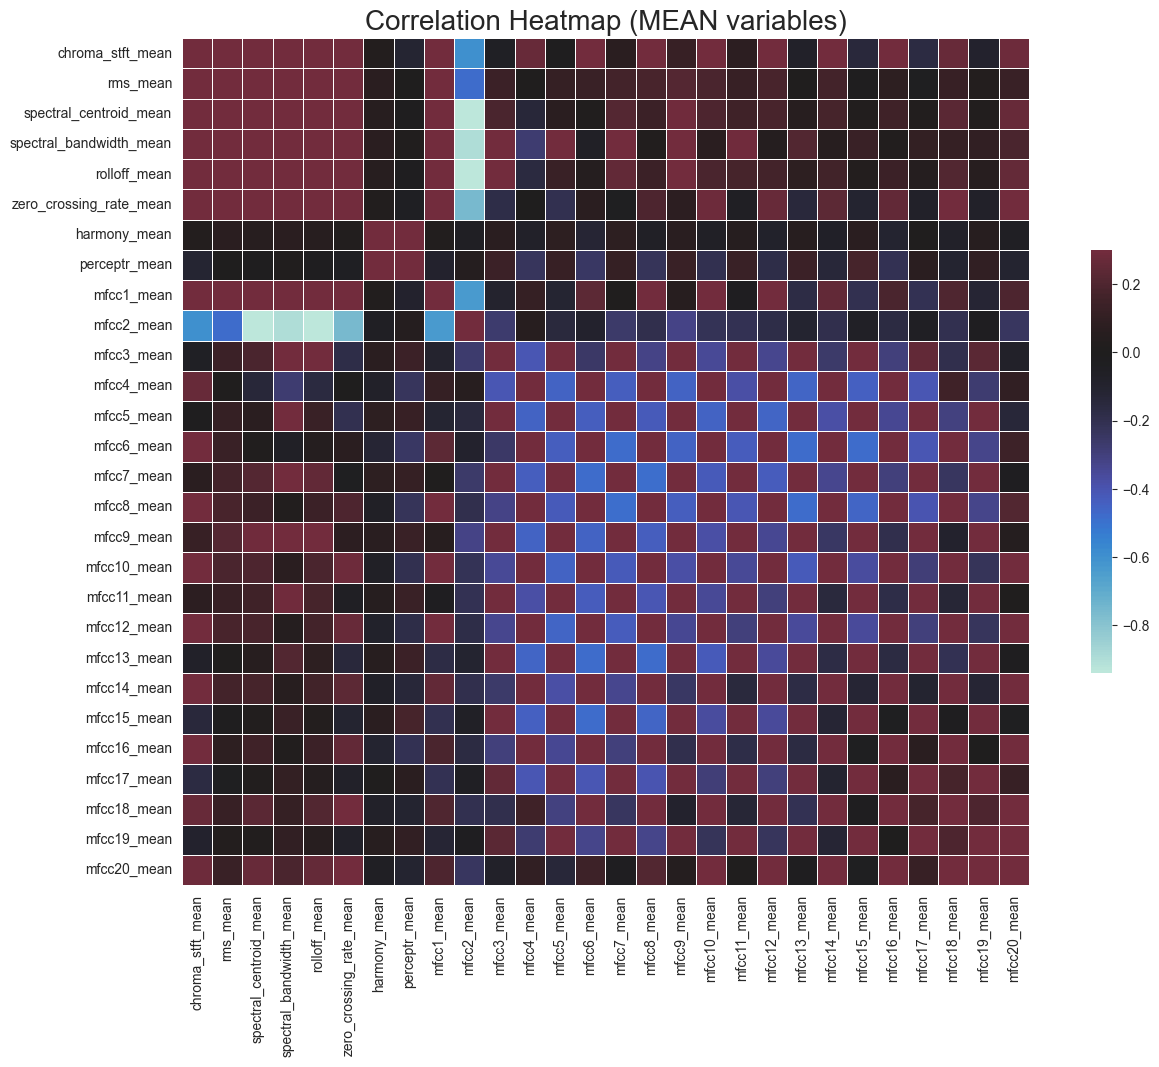

In [20]:
#Study the theory of correlation how to use correlation to fing the appropriate features to use in the model traning


#Correlation matrix calculation using coumns with mean values

# this will take out all the names of columns whose name contain mean
meanCols = [col for col in musicData.columns if 'mean' in col]

#finding the correlation 
corr = musicData[meanCols].corr()

#plotting the correlation matrix figure

f,ax = plt.subplots(figsize=(16,11));
sns.heatmap(corr, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (MEAN variables)', fontsize = 20)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_heatmap.png")


"""
    in the heat map, warm colors represent hig values and cool values represent low values. Values in a correlation matrix
    range from -1 to 1. A value of one indicates a perfect positive correlation meaning as one value increases, the other
    also increases. A value of -1 indicates a perfect negative correlation meaning as one value 
    increases, the other decreases. Avalue of 0 indicates no correlation between the variables.

"""

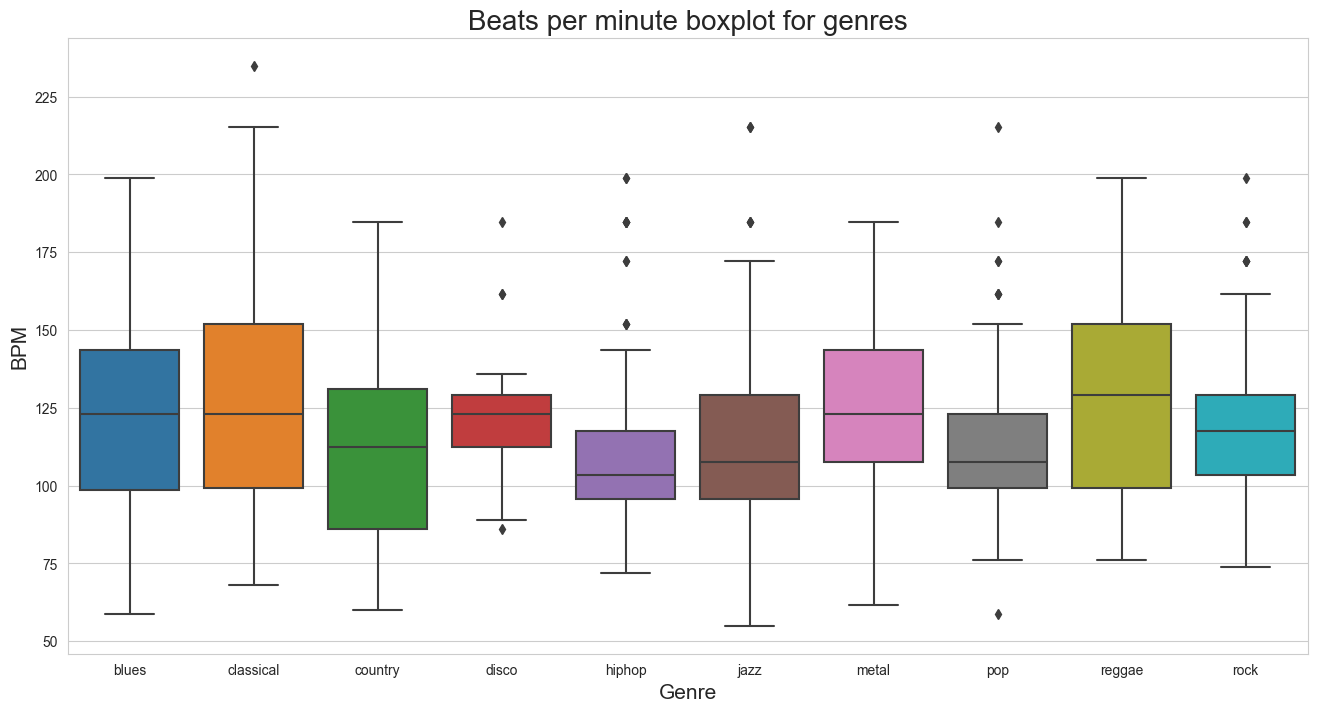

In [21]:
"""
considering the beats per mintues as an essential feature to find the rythm of music so that we can find the genre of music 
drawing the box plot of beats for each music genere
study box plots how use them and how to extract information from it
"""

x = musicData[['label', 'tempo']]
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x ='label', y='tempo', data=x)

plt.title('Beats per minute boxplot for genres', fontsize=20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Genre', fontsize = 15)
plt.ylabel('BPM', fontsize = 15)
plt.savefig("Beats_Per_Minute.png")


In [22]:
#lets convert label to intergers it will be easier to work with them

labelIndex = dict()
for i, x in enumerate(musicData.label.unique()):
    labelIndex[x] = i
    
print(labelIndex)

labels = musicData.label.unique()
print(labels)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [23]:
#update labels in df to index
musicData.label = [labelIndex[l] for l in musicData.label]

In [24]:
#splitting data into training, testing and validatoin sets

#with the help of this i will shuffle the data as currently data is set according to label
dataShuffle = musicData.sample(frac=1, random_state = 12).reset_index(drop=True)

#data cleaning
dataShuffle.drop(['filename', 'length'], axis=1, inplace=True)
dataY = dataShuffle.pop('label')
dataX = dataShuffle


#split original dataset into train and test
Xtrain, Xtest, Ytrain, Ytest = skms.train_test_split(dataX, dataY, train_size=0.9, random_state=12, stratify=dataY)

#use of stratify:- all sets will hae equal proportion of genres

In [25]:
def results(model, X, Y):
    Ytrue = Y
    
    Yprediction = model.predict(X)
#     calculation of confusion matirx
    confusionMatrix = skm.confusion_matrix(Ytrue, Yprediction)
    
    plt.figure(figsize = (6.5,6.5))  #This is the size of the image
    heatM = sns.heatmap(confusionMatrix, vmin = 0, vmax =9 ,center = 0, cmap = sns.diverging_palette(20, 220, n = 200),  square = True, annot = True) #this are the caracteristics of the heatmap
    heatM.set_ylim([10,0]) # This is the limit in y axis (number of features)
    
    plt.show()
#   use of digit in classification report fucntion
    report =  skm.classification_report(Ytrue, Yprediction, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    print(df_classification_report.to_markdown())
    
    
#     print(skm.precision_recall_fscore_support(Ytrue, Yprediction, average="macro"))

In [26]:
#using random forest algorithm on entire data set
rfc = ske.RandomForestClassifier(random_state=12, n_jobs=-1)
rfc.fit(Xtrain, Ytrain)

RandomForestClassifier(n_jobs=-1, random_state=12)

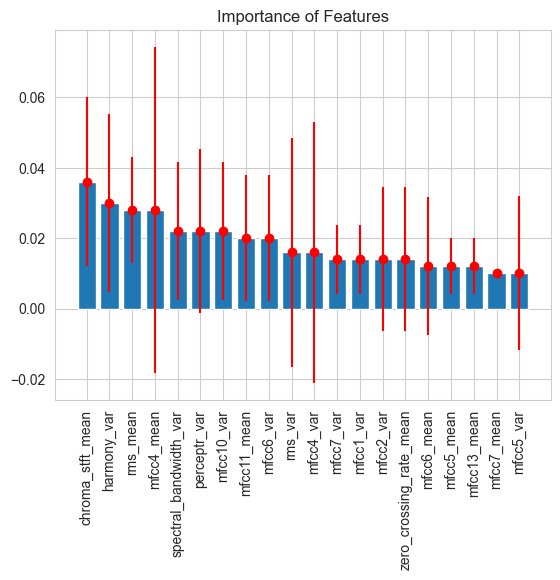

In [27]:
perm = PermutationImportance(estimator=rfc, random_state=1)
perm.fit(Xtest, Ytest)
w = eli5.show_weights(estimator=perm, feature_names = Xtest.columns.tolist())

result = pd.read_html(w.data)[0]
weight = pd.DataFrame(columns = ['Weight'])
error = pd.DataFrame(columns = ['Error'])

for i in range(len(result)-1):
    weight = weight.append(pd.Series(float(result.iloc[i]['Weight'][:6]), index = weight.columns), ignore_index=True)
    error = error.append(pd.Series(float(result.iloc[i]['Weight'][-6:]), index = error.columns), ignore_index=True)


plt.bar(result.iloc[:-1]['Feature'], weight['Weight'])
plt.errorbar(result.iloc[:-1]['Feature'], weight['Weight'], yerr=error['Error'], fmt="o", color="r")
plt.xticks(rotation='vertical')
plt.title("Importance of Features")
plt.show(block=True)

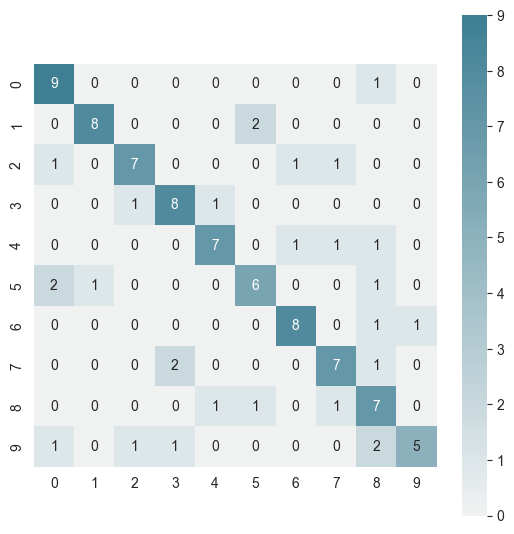

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.692308 |     0.9  |   0.782609 |     10    |
| 1            |    0.888889 |     0.8  |   0.842105 |     10    |
| 2            |    0.777778 |     0.7  |   0.736842 |     10    |
| 3            |    0.727273 |     0.8  |   0.761905 |     10    |
| 4            |    0.777778 |     0.7  |   0.736842 |     10    |
| 5            |    0.666667 |     0.6  |   0.631579 |     10    |
| 6            |    0.8      |     0.8  |   0.8      |     10    |
| 7            |    0.7      |     0.7  |   0.7      |     10    |
| 8            |    0.5      |     0.7  |   0.583333 |     10    |
| 9            |    0.833333 |     0.5  |   0.625    |     10    |
| accuracy     |    0.72     |     0.72 |   0.72     |      0.72 |
| macro avg    |    0.736402 |     0.72 |   0.720022 |    100    |
| weighted avg |    0.736402 |     0.72 |   0.720022 |    100 

In [28]:
results(rfc, Xtest, Ytest)

In [29]:
def audioConversionMP3toWAV(songDestination, wavDestination):
    # external files used to remve the error file not found when importing music file
    AudioSegment.converter = "ffmpeg.exe"
    AudioSegment.ffmpeg = "ffmpeg.exe"
    AudioSegment.ffprobe="ffprobe.exe"

    # Convert wav to mp3
    sound = AudioSegment.from_mp3(src)
    sound.export(dst,format="wav")

In [30]:
def loadAudio(wavDestination):
    audio_fp = wavDestination
    audio_data, sr = librosa.load(audio_fp)
    audio_data, _ = librosa.effects.trim(audio_data)
    # play sample file
    IPython.display.Audio(audio_data, rate=sr)
    return audio_data, sr
    

In [31]:
def createChunks(wavDestination):
    #create chunks
    audion, sr =loadAudio(wavDestination)
    myaudio = AudioSegment.from_file(wavDestination , "wav") 
    chunk_length_ms = 22050*30 # pydub calculates in millisec
    chunks = make_chunks(audio, chunk_length_ms) #Make chunks of one sec
    return chunks

In [32]:
src = 'songs/classicalSong.mp3'
dst = 'test1.wav'

audioConversionMP3toWAV(src,dst)

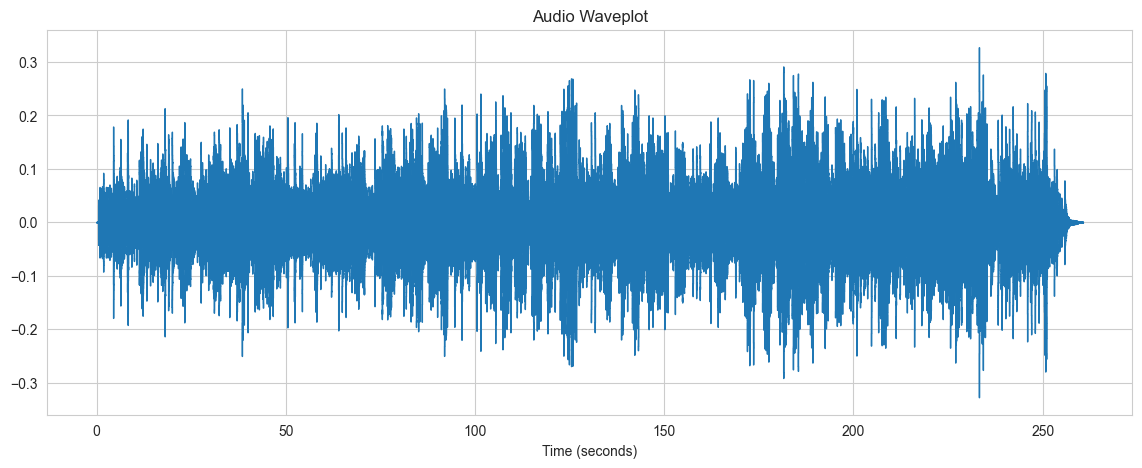

In [33]:
plt.figure(figsize=(14,5))
plt.title("Audio Waveplot")
audio, sr = loadAudio(dst) 
librosa.display.waveshow(audio, sr=sr, axis="s")
plt.show()

In [34]:
def prediction(chunk):
    chroma = librosa.feature.chroma_stft(y=chunk, sr=sr)
    chroma_stft_mean=chroma.mean()
    chroma_stft_var = chroma.var()
    rms= librosa.feature.rms(y=chunk)
    rms_mean = rms.mean()
    rms_var = rms.var()
    cent = librosa.feature.spectral_centroid(y=chunk, sr=sr)
    spectral_centroid_mean = cent.mean()
    spectral_centroid_var = cent.var()
    spec_bw = librosa.feature.spectral_bandwidth(y=chunk, sr=sr)
    spectral_bandwidth_mean = spec_bw.mean()
    spectral_bandwidth_var = spec_bw.var()
    rolloff =librosa.feature.spectral_rolloff(y=chunk, sr=sr)
    rolloff_mean = rolloff.mean()
    rolloff_var = rolloff.var()
    zcr = librosa.feature.zero_crossing_rate(y=chunk)
    zero_crossing_rate_mean= zcr.mean()
    zero_crossing_rate_var = zcr.var()
    tempo, beats = librosa.beat.beat_track(y=chunk,sr=sr)
    y_harmonic, y_percussive = librosa.effects.hpss(y=chunk)
    y_harmonic_rate_mean = y_harmonic.mean()
    y_harmonic_rate_var = y_harmonic.var()
    perceptr_mean = y_percussive.mean()
    perceptr_var = y_percussive.var()
    mfccs = librosa.feature.mfcc(y=chunk, sr=sr)
    mfccs_df = pd.DataFrame(mfccs)
    mfccs_df['mean'] = mfccs_df.mean(axis=1)
    mfccs_df['var'] = mfccs_df.var(axis=1)
    df = pd.DataFrame(columns = ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var','perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var'], index = ['a'])
    df.loc['a'] = [chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spectral_centroid_mean, spectral_centroid_var, spectral_bandwidth_mean, spectral_bandwidth_var, rolloff_mean, rolloff_var, zero_crossing_rate_mean, zero_crossing_rate_var, y_harmonic_rate_mean, y_harmonic_rate_var,perceptr_mean,perceptr_mean, tempo, mfccs_df.iloc[0]['mean'], mfccs_df.iloc[0]['var'], mfccs_df.iloc[1]['mean'], mfccs_df.iloc[1]['var'], mfccs_df.iloc[2]['mean'], mfccs_df.iloc[2]['var'], mfccs_df.iloc[3]['mean'], mfccs_df.iloc[3]['var'], mfccs_df.iloc[4]['mean'], mfccs_df.iloc[4]['var'], mfccs_df.iloc[5]['mean'], mfccs_df.iloc[5]['var'], mfccs_df.iloc[6]['mean'], mfccs_df.iloc[6]['var'], mfccs_df.iloc[7]['mean'], mfccs_df.iloc[7]['var'], mfccs_df.iloc[8]['mean'], mfccs_df.iloc[8]['var'], mfccs_df.iloc[9]['mean'], mfccs_df.iloc[9]['var'], mfccs_df.iloc[10]['mean'], mfccs_df.iloc[10]['var'], mfccs_df.iloc[11]['mean'], mfccs_df.iloc[11]['var'], mfccs_df.iloc[12]['mean'], mfccs_df.iloc[12]['var'], mfccs_df.iloc[13]['mean'], mfccs_df.iloc[13]['var'], mfccs_df.iloc[14]['mean'], mfccs_df.iloc[14]['var'], mfccs_df.iloc[15]['mean'], mfccs_df.iloc[15]['var'], mfccs_df.iloc[16]['mean'], mfccs_df.iloc[16]['var'], mfccs_df.iloc[17]['mean'], mfccs_df.iloc[17]['var'], mfccs_df.iloc[18]['mean'], mfccs_df.iloc[18]['var'], mfccs_df.iloc[19]['mean'], mfccs_df.iloc[19]['var']]
    return rfc.predict(df)

In [35]:
def recommendation():
    chunks=createChunks(dst)
    temp = pd.DataFrame(columns = ['Time Started', 'Time Ended', 'Genre Found'])
    dataSet = pd.read_csv(r"features_30_sec.csv")
    for i, chunk in enumerate(chunks):
        predictChunk = prediction(chunk)
        row1 = pd.Series([i*30, (i+1)*30, labels[predictChunk][0]], index=temp.columns)
        temp = temp.append(row1,ignore_index=True)
        count = 0
        variable = dataSet.loc[dataSet['label'] == labels[predictChunk][0]]
        #print(variable)
        print(temp.iloc[i].to_frame().T)
        for j in range(4):
            r1 = random.randint(0, len(variable)-2)
            print(variable.iloc[r1]['filename'])


    print(temp.to_markdown())

In [36]:
recommendation()

  Time Started Time Ended Genre Found
0            0         30   classical
classical.00023.wav
classical.00006.wav
classical.00012.wav
classical.00096.wav
  Time Started Time Ended Genre Found
1           30         60   classical
classical.00038.wav
classical.00086.wav
classical.00010.wav
classical.00059.wav
  Time Started Time Ended Genre Found
2           60         90   classical
classical.00087.wav
classical.00033.wav
classical.00007.wav
classical.00042.wav
  Time Started Time Ended Genre Found
3           90        120   classical
classical.00041.wav
classical.00066.wav
classical.00003.wav
classical.00010.wav
  Time Started Time Ended Genre Found
4          120        150   classical
classical.00005.wav
classical.00055.wav
classical.00083.wav
classical.00007.wav
  Time Started Time Ended Genre Found
5          150        180   classical
classical.00012.wav
classical.00023.wav
classical.00008.wav
classical.00053.wav
  Time Started Time Ended Genre Found
6          180        210 